In [1]:
# https://huggingface.co/datasets/FronkonGames/steam-games-dataset
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Load the data and print summary information

In [2]:
with open('games.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

total_games = len(data)

zero_reviews = 0
for appid, game in data.items():
    if game['positive'] == 0 and game['negative'] == 0:
        zero_reviews = zero_reviews + 1

print("Total games on Steam:", total_games)
print("Total games on Steam with zero reviews:", zero_reviews)
print(f"{100 * (zero_reviews / total_games):.1f}% of all games on Steam have 0 reviews, positive or negative")

free_games = {}
paid_games = {}

for appid, game in data.items():
    if game['price'] == 0:
        free_games[appid] = game
    else:
        paid_games[appid] = game

print(f"Free games: {len(free_games):,}")
print(f"Paid games: {len(paid_games):,}")
print(f"{100 * (len(free_games) / total_games):.1f}% of all games on Steam are free")

Total games on Steam: 111452
Total games on Steam with zero reviews: 37588
33.7% of all games on Steam have 0 reviews, positive or negative
Free games: 23,247
Paid games: 88,205
20.9% of all games on Steam are free


## Check the range of dates in our data

In [3]:
parsed_dates = []
for game in data.values():
    date_str = game['release_date']
    try:
        # Steam release dates come in 3 formats:
        # "Oct 21, 2008" (full date), "May 2020" (month/year), "2008" (year only)
        if ',' in date_str:
            dt = datetime.strptime(date_str, '%b %d, %Y')
        elif len(date_str.split()) == 2:
            dt = datetime.strptime(date_str, '%b %Y')
        else:
            dt = datetime.strptime(date_str, '%Y')
        parsed_dates.append((dt, game['name'], date_str))
    except:
        pass

sorted_dates = sorted(parsed_dates, key=lambda x: x[0])

print("First game in the dataset:")
print(f"  {sorted_dates[0][1]}")
print(f"  Released: {sorted_dates[0][2]}")

print("\nLast game in the dataset:")
print(f"  {sorted_dates[-1][1]}")
print(f"  Released: {sorted_dates[-1][2]}")

# Find last April 2025 date
april_2025_dates = [d for d in sorted_dates if d[0].year == 2025 and d[0].month == 4]
if april_2025_dates:
    last_april = april_2025_dates[-1]
    print(f"\nNote: April 2025 data is incomplete (last entry: {last_april[2]})")
    print("Analysis will stop at March 2025 in order to avoid incomplete months")

First game in the dataset:
  Carmageddon Max Pack
  Released: Jun 30, 1997

Last game in the dataset:
  Orb Raid Dedicated Server
  Released: May 30, 2025

Note: April 2025 data is incomplete (last entry: Apr 21, 2025)
Analysis will stop at March 2025 in order to avoid incomplete months


## Number of Games by Genre

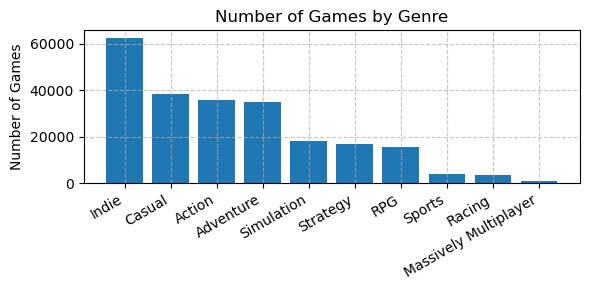

In [4]:
official_genres = ['Action', 'Adventure', 'Casual', 'Indie', 'Massively Multiplayer', 
                   'Racing', 'RPG', 'Simulation', 'Sports', 'Strategy']

genre_counts = {}
for genre in official_genres:
    genre_counts[genre] = 0

for appid, game in paid_games.items():
    for genre in game['genres']:
        if genre in official_genres:
            genre_counts[genre] = genre_counts[genre] + 1

sorted_items = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
genres = [item[0] for item in sorted_items]
counts = [item[1] for item in sorted_items]

plt.figure(figsize=(6, 3))
plt.bar(genres, counts)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Number of Games')
plt.title('Number of Games by Genre')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('number_of_games_by_genre.png')

## Price Distribution

Most products over $100 on Steam seem to be software or games with nearly 0 sales. For this reason, games over $100 have been excluded to help the plot’s clarity, however, they are still averaged into the mean.


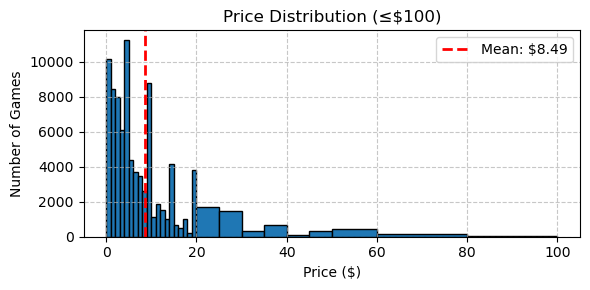

In [5]:
prices = [game['price'] for game in paid_games.values() if game['price'] <= 100]

bins = list(range(0, 21, 1)) + list(range(25, 51, 5)) + list(range(60, 101, 20))

mean_price = np.mean(prices)

print("Most products over $100 on Steam seem to be software or games with nearly 0 sales. For this reason, games over $100 have been excluded to help the plot’s clarity, however, they are still averaged into the mean.")

plt.figure(figsize=(6, 3))
plt.hist(prices, bins=bins, edgecolor='black')
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_price:.2f}')
plt.xlabel('Price ($)')
plt.ylabel('Number of Games')
plt.title('Price Distribution (≤$100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('price_distribution.png')

## Review score distribution

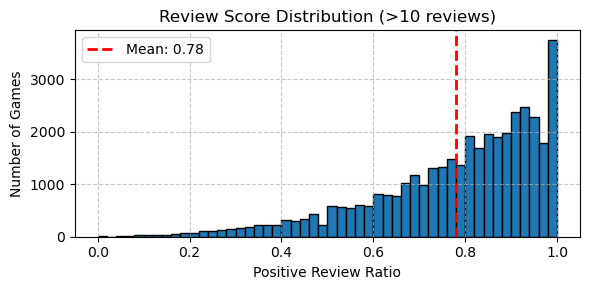

In [6]:
pos_ratios = []
for game in paid_games.values():
    total = game['positive'] + game['negative']
    if total > 10:
        pos_ratios.append(game['positive'] / total)

mean_reviews = np.mean(pos_ratios)

plt.figure(figsize=(6, 3))
plt.hist(pos_ratios, bins=50, edgecolor='black')
plt.axvline(mean_reviews, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_reviews:.2f}')
plt.legend()
plt.xlabel('Positive Review Ratio')
plt.ylabel('Number of Games')
plt.title('Review Score Distribution (>10 reviews)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('review_score_distribution.png')

## New releases each month

games with no month:  0


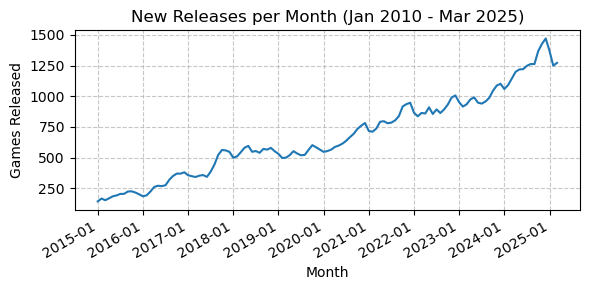

In [7]:
month_counts = {}
k=0
for game in paid_games.values():
    date_str = game['release_date']
    try:
        if ',' in date_str:
            date = datetime.strptime(date_str, '%b %d, %Y')
        elif len(date_str.split()) == 2:
            date = datetime.strptime(date_str, '%b %Y')
        else:
            k+=1
            date = datetime.strptime(date_str, '%Y')
        
        if datetime(2015, 1, 1) <= date < datetime(2025, 4, 1):
            month_key = date.strftime('%Y-%m')
            if month_key not in month_counts:
                month_counts[month_key] = 0
            month_counts[month_key] += 1
    except:
        pass
print("games with no month: ", k)
sorted_months = sorted(month_counts.items())
months = [m[0] for m in sorted_months]
counts = [m[1] for m in sorted_months]

# 3-month rolling average
rolling_avg = []
for i in range(len(counts)):
    if i < 2:
        rolling_avg.append(counts[i])
    else:
        rolling_avg.append(sum(counts[i-2:i+1]) / 3)

plt.figure(figsize=(6, 3))
plt.plot(range(len(months)), rolling_avg, linewidth=1.5)
tick_positions = range(0, len(months), 12)
tick_labels = [months[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=30, ha='right')
plt.xlabel('Month')
plt.ylabel('Games Released')
plt.title('New Releases per Month (Jan 2010 - Mar 2025)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('new_releases_per_month.png')

## Number of publications by developer

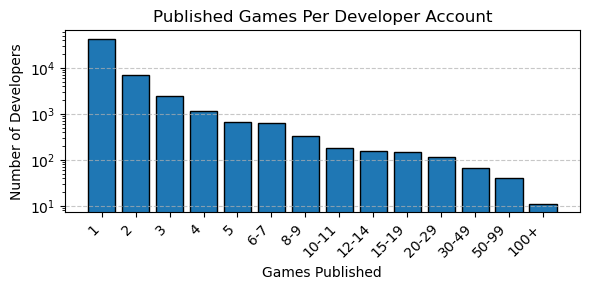

Mean: 1.7 games/developer
Total developers: 56,062

The top 10 most prolific developers:
  EroticGamesClub: 216 games
  Choice of Games: 166 games
  Atomic Fabrik: 157 games
  Laush Dmitriy Sergeevich: 150 games
  Boogygames Studios: 144 games
  Creobit: 144 games
  Tero Lunkka: 120 games
  Cristian Manolachi: 117 games
  Hosted Games: 114 games
  Sokpop Collective: 109 games


In [8]:
# Build developer counts
dev_counts = {}
for game in paid_games.values():
    for dev in game['developers']:
        if dev not in dev_counts:
            dev_counts[dev] = 0
        dev_counts[dev] = dev_counts[dev] + 1

# Get all developer counts
all_counts = list(dev_counts.values())
all_counts.sort(reverse=True)

# Variable bins
bins = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 30, 50, 100, max(all_counts)+1]
bin_labels = ['1', '2', '3', '4', '5', '6-7', '8-9', '10-11', '12-14', '15-19', '20-29', '30-49', '50-99', '100+']

hist_counts = []
for i in range(len(bins)-1):
    count = sum(1 for c in all_counts if bins[i] <= c < bins[i+1])
    hist_counts.append(count)

mean_games = sum(all_counts) / len(all_counts)
median_games = all_counts[len(all_counts) // 2]

plt.figure(figsize=(6, 3))
plt.bar(bin_labels, hist_counts, edgecolor='black')
plt.xlabel('Games Published')
plt.ylabel('Number of Developers')
plt.title('Published Games Per Developer Account')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.yscale("log")
plt.tight_layout()
plt.savefig('games_per_developer.png')
plt.show()

print(f"Mean: {mean_games:.1f} games/developer")
print(f"Total developers: {len(all_counts):,}")
print()
print("The top 10 most prolific developers:")
sorted_devs = sorted(dev_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for dev, count in sorted_devs:
    print(f"  {dev}: {count:,} games")

## Average Playtime

Top 26 games by average playtime:
1. Boom 3D: 2,428.8 hours
2. Energy Engine PC Live Wallpaper: 1,737.3 hours
3. YoloMouse: 1,082.9 hours
4. WARRIORS ALL-STARS: 856.5 hours
5. Combat Mission Shock Force 2: 788.9 hours
6. Brigade E5: New Jagged Union: 712.9 hours
7. Holoswitch: 626.0 hours
8. FPS Monitor – hardware in-game & desktop overlays: 612.9 hours
9. 时之回廊/Corridor of time: 555.7 hours
10. 江湖余生：缘起: 537.1 hours
11. Clicker Heroes 2: 528.5 hours
12. FINAL FANTASY XIV Online: 458.0 hours
13. RutonyChat: 456.6 hours
14. Project AURA: 447.1 hours
15. Hold your houses: 423.8 hours
16. Rugby Union Team Manager 2017: 357.1 hours
17. Summer Pockets: 351.9 hours
18. HudSight - custom crosshair overlay: 338.3 hours
19. OVR Toolkit: 337.7 hours
20. Jagged Alliance 1: Gold Edition: 304.2 hours
21. XSOverlay: 303.9 hours
22. Cookie Clicker: 291.6 hours
23. CPUCores :: Maximize Your FPS: 286.0 hours
24. Beasts of Bermuda: 285.8 hours
25. Soundpad: 284.6 hours
26. Rust: 277.1 hours


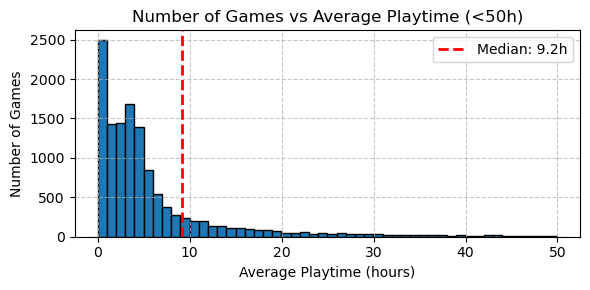

In [9]:
playtimes = [game['average_playtime_forever'] for game in paid_games.values() if game['average_playtime_forever'] > 0]
playtimes_array = np.array(playtimes) / 60  # Convert to hours

median_playtime = np.mean(playtimes_array)

plt.figure(figsize=(6, 3))
plt.hist(playtimes_array[playtimes_array < 50], bins=50, edgecolor='black')
plt.axvline(median_playtime, color='red', linestyle='--', linewidth=2, label=f'Median: {median_playtime:.1f}h')
plt.xlabel('Average Playtime (hours)')
plt.ylabel('Number of Games')
plt.title('Number of Games vs Average Playtime (<50h)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('playtime_distribution.png')

# Top 10 games by playtime
playtime_games = [(game['name'], game['average_playtime_forever'] / 60) 
                  for game in paid_games.values() 
                  if game['average_playtime_forever'] > 0]
playtime_games.sort(key=lambda x: x[1], reverse=True)

print("Top 26 games by average playtime:")
for i, (name, hours) in enumerate(playtime_games[:26], 1):
    print(f"{i}. {name}: {hours:,.1f} hours")

## Ownership tiers distribution

Total paid games: 88,205

Games with <100K owners: 79,617 (90.3%)
Games with <1M owners: 86,741 (98.3%)
Games with ≥1M owners: 748 (0.8%)
Games with ≥10M owners: 36 (0.0%)


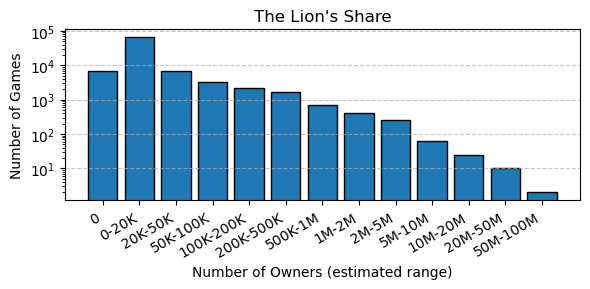

In [16]:
ownership_ranges = {
    '0 - 0': 0,
    '0 - 20000': 10000,
    '20000 - 50000': 35000,
    '50000 - 100000': 75000,
    '100000 - 200000': 150000,
    '200000 - 500000': 350000,
    '500000 - 1000000': 750000,
    '1000000 - 2000000': 1500000,
    '2000000 - 5000000': 3500000,
    '5000000 - 10000000': 7500000,
    '10000000 - 20000000': 15000000,
    '20000000 - 50000000': 35000000,
    '50000000 - 100000000': 75000000,
    '100000000 - 200000000': 150000000
}

def parse_tier(tier_str):
    parts = tier_str.replace(',', '').split('-')
    low = int(parts[0].strip())
    high = int(parts[1].strip())
    return (low, high)

def abbrev_number(num):
    if num >= 1000000:
        return f"{num/1000000:.0f}M"
    elif num >= 1000:
        return f"{num/1000:.0f}K"
    return str(num)

def abbrev_tier(tier_str):
    low, high = parse_tier(tier_str)
    if low == 0 and high == 0:
        return '0'
    else:
        return f"{abbrev_number(low)}-{abbrev_number(high)}"

ownership_tiers = {}
for game in paid_games.values():
    tier = game['estimated_owners']
    ownership_tiers[tier] = ownership_tiers.get(tier, 0) + 1

sorted_tiers = sorted(ownership_tiers.items(), key=lambda x: parse_tier(x[0]))
labels = [abbrev_tier(t[0]) for t in sorted_tiers]
counts = [t[1] for t in sorted_tiers]

plt.figure(figsize=(6, 3))
plt.bar(range(len(labels)), counts, edgecolor='black')
plt.xticks(range(len(labels)), labels, rotation=30, ha='right')
plt.xlabel('Number of Owners (estimated range)')
plt.ylabel('Number of Games')
plt.title('The Lion\'s Share')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.tight_layout()
plt.savefig('ownership_tiers_log.png')

# Quantify the lion's share
total_games = sum(counts)

# Games with <100K owners
small_games = sum(counts[i] for i in range(len(sorted_tiers)) if parse_tier(sorted_tiers[i][0])[1] < 100000)
small_pct = (small_games / total_games) * 100

# Games with <1M owners
mid_games = sum(counts[i] for i in range(len(sorted_tiers)) if parse_tier(sorted_tiers[i][0])[1] < 1000000)
mid_pct = (mid_games / total_games) * 100

# Games with >1M owners
big_games = sum(counts[i] for i in range(len(sorted_tiers)) if parse_tier(sorted_tiers[i][0])[0] >= 1000000)
big_pct = (big_games / total_games) * 100

# Games with >10M owners
huge_games = sum(counts[i] for i in range(len(sorted_tiers)) if parse_tier(sorted_tiers[i][0])[0] >= 10000000)
huge_pct = (huge_games / total_games) * 100

print(f"Total paid games: {total_games:,}")
print(f"\nGames with <100K owners: {small_games:,} ({small_pct:.1f}%)")
print(f"Games with <1M owners: {mid_games:,} ({mid_pct:.1f}%)")
print(f"Games with ≥1M owners: {big_games:,} ({big_pct:.1f}%)")
print(f"Games with ≥10M owners: {huge_games:,} ({huge_pct:.1f}%)")

## Ownership vs reviews

Mean review rate: 0.92% of owners leave reviews


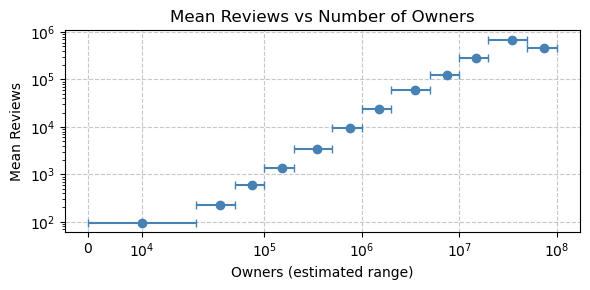

In [11]:
ownership_vals = []
review_vals = []

for game in paid_games.values():
    tier = game['estimated_owners']
    total_reviews = game['positive'] + game['negative']
    
    if tier in ownership_ranges and total_reviews > 0:
        ownership_vals.append(ownership_ranges[tier])
        review_vals.append(total_reviews)

# Group by ownership tier
tier_review_stats = {}
tier_bounds = {}
for i in range(len(ownership_vals)):
    tier = ownership_vals[i]
    if tier not in tier_review_stats:
        tier_review_stats[tier] = []
        for tier_str, midpoint in ownership_ranges.items():
            if midpoint == tier:
                low, high = parse_tier(tier_str)
                tier_bounds[tier] = (low if low > 0 else 1, high if high > 0 else 1)
                break
    tier_review_stats[tier].append(review_vals[i])

sorted_tiers = sorted(tier_review_stats.keys())
mean_reviews = [np.mean(tier_review_stats[tier]) for tier in sorted_tiers]
x_mins = [tier_bounds[tier][0] for tier in sorted_tiers]
x_maxs = [tier_bounds[tier][1] for tier in sorted_tiers]

plt.figure(figsize=(6, 3))
for i in range(len(sorted_tiers)):
    plt.errorbar(sorted_tiers[i], mean_reviews[i], 
                 xerr=[[sorted_tiers[i]-x_mins[i]], [x_maxs[i]-sorted_tiers[i]]], 
                 fmt='o', markersize=6, capsize=3, color='steelblue')
plt.xscale('symlog', linthresh=20000)
plt.yscale('log')
plt.xlabel('Owners (estimated range)')
plt.ylabel('Mean Reviews')
plt.title('Mean Reviews vs Number of Owners')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ownership_vs_reviews.png')

review_rate = np.mean([review_vals[i]/ownership_vals[i] for i in range(len(ownership_vals))])
print(f"Mean review rate: {review_rate*100:.2f}% of owners leave reviews")

### Chance for an Owner to Review vs Owner Count

Review rate for games with <100K owners: 0.90%
Review rate for games with ≥1M owners: 1.64%


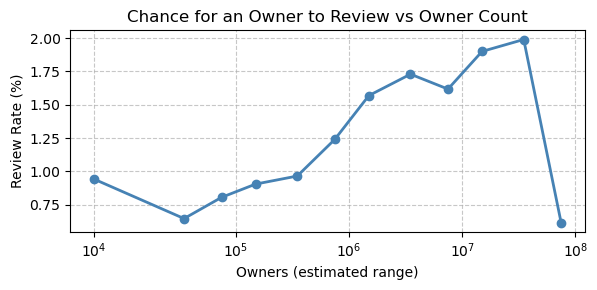

In [12]:
tier_review_rates = {}
for i in range(len(ownership_vals)):
    tier = ownership_vals[i]
    rate = review_vals[i] / ownership_vals[i]
    if tier not in tier_review_rates:
        tier_review_rates[tier] = []
    tier_review_rates[tier].append(rate)

sorted_tiers = sorted(tier_review_rates.keys())
mean_rates = [np.mean(tier_review_rates[tier]) * 100 for tier in sorted_tiers]

plt.figure(figsize=(6, 3))
plt.plot(sorted_tiers, mean_rates, marker='o', linewidth=2, markersize=6, color='steelblue')
plt.xscale('symlog', linthresh=20000)
plt.xlabel('Owners (estimated range)')
plt.ylabel('Review Rate (%)')
plt.title('Chance for an Owner to Review vs Owner Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('review_rate_by_ownership.png')

# Print stats
print(f"Review rate for games with <100K owners: {np.mean([r for t, rates in tier_review_rates.items() for r in rates if t < 100000])*100:.2f}%")
print(f"Review rate for games with ≥1M owners: {np.mean([r for t, rates in tier_review_rates.items() for r in rates if t >= 1000000])*100:.2f}%")

### Metacritic scores

Games with Metacritic scores: 3,695 (4.2%)


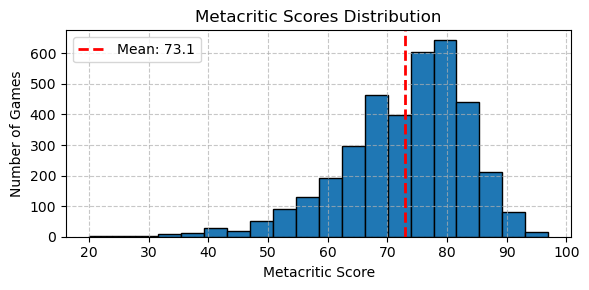

In [13]:
metacritic_scores = [game['metacritic_score'] for game in paid_games.values() if game['metacritic_score'] > 0]
mean_score = np.mean(metacritic_scores)

plt.figure(figsize=(6, 3))
plt.hist(metacritic_scores, bins=20, edgecolor='black')
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.1f}')
plt.xlabel('Metacritic Score')
plt.ylabel('Number of Games')
plt.title('Metacritic Scores Distribution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('metacritic_scores.png')

print(f"Games with Metacritic scores: {len(metacritic_scores):,} ({100*len(metacritic_scores)/len(paid_games):.1f}%)")

## Releases Each Month

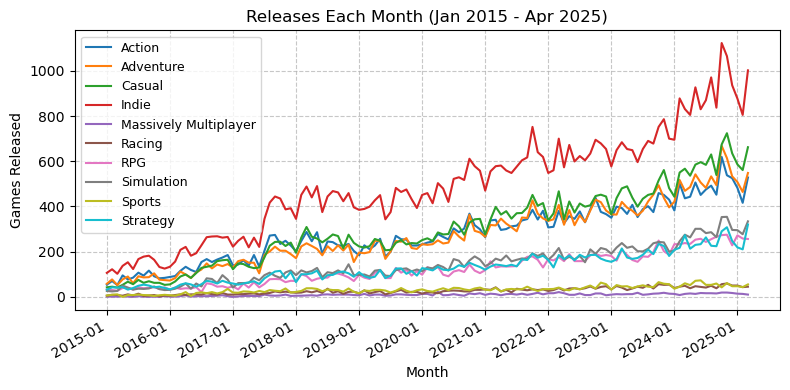

In [14]:
genre_by_month = {}
for game in paid_games.values():
    date_str = game['release_date']
    try:
        if ',' in date_str:
            date = datetime.strptime(date_str, '%b %d, %Y')
        elif len(date_str.split()) == 2:
            date = datetime.strptime(date_str, '%b %Y')
        else:
            date = datetime.strptime(date_str, '%Y')
        
        if datetime(2015, 1, 1) <= date < datetime(2025, 4, 1):
            month_key = date.strftime('%Y-%m')
            for genre in game['genres']:
                if genre in official_genres:
                    if genre not in genre_by_month:
                        genre_by_month[genre] = {}
                    if month_key not in genre_by_month[genre]:
                        genre_by_month[genre][month_key] = 0
                    genre_by_month[genre][month_key] += 1
    except:
        pass

months = []
current = datetime(2015, 1, 1)
while current < datetime(2025, 4, 1):
    months.append(current.strftime('%Y-%m'))
    current += timedelta(days=32)
    current = current.replace(day=1)

plt.figure(figsize=(8, 4))
for genre in official_genres:
    counts = [genre_by_month.get(genre, {}).get(month, 0) for month in months]
    plt.plot(range(len(months)), counts, linewidth=1.5, label=genre)

tick_positions = range(0, len(months), 12)
tick_labels = [months[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=30, ha='right')

plt.xlabel('Month')
plt.ylabel('Games Released')
plt.title('Releases Each Month (Jan 2015 - Apr 2025)')
plt.legend(fontsize=9, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('releases_each_month.png')

## Early Access vs Released

In [15]:
early_access_count = sum(1 for game in paid_games.values() if 'Early Access' in game['genres'])
released_count = len(paid_games) - early_access_count

print(f"Released: {released_count:,} ({100*released_count/len(paid_games):.1f}%)")
print(f"Early Access: {early_access_count:,} ({100*early_access_count/len(paid_games):.1f}%)")

Released: 76,661 (86.9%)
Early Access: 11,544 (13.1%)
